# Gradient Descent Optimization

## Table of contents:
* [Vanilla Gradient Descent](#vanilla)
* [Stochastic Gradient Descent](#sgd)
* [Minibatch Gradient Descent](#minibatch)
* [Momentum](#momentum)
* [Nesterov Momentum](#nag)
* [Adagrad](#adagrad)
* [RMS Prop](#rms)
* [Adam](#adam)

# Gradient descent methods

In training models, we often like to optimize parameters to minimize user-defined cost functions $L\big(\{\mathbf{x}\}_{i=1}^{N}, \{w\}_{i=1}^{N}, \mathbf{\theta}\big)$. The gradient descent methods aim to achieve it by efficiently rolling down the high-dimensional landscape of the cost function $L$. One of its advantages is that it employs only the first order derivative of the cost function with respect to the parameters as opposed to the Newton's method which requires the second order derivatives  more or less in the opposite direction of the gradient.

Thus, the method concerns:<br>
(1) in which direction to update <br>
(2) how large step to make for the update (often named learning rate $\alpha$)<br>
(3) how much portion of the samples to take into accout for each update<br>

$$\begin{align}
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + learning\,rate * direction\\
direction \quad & = &\quad -gradient \qquad or \qquad some\,other\,chosen\,direction\\
learning\,rate \quad & = &\quad common\,to\,all\,the\,parameters \qquad or \qquad different\,for\,each\,parameter\\
samples\,taken\,into\,account \quad & = &\quad all \qquad or \qquad partial
\end{align}$$

Note that if one chooses a too-large learning rate, the next step might overshoot the valley, might reach the hill on the other side, and might even diverge by repeatedly bounching up the hills. Often, $learning\,rate = \alpha$ is annealed (shrunken) as the step progresses. 


# Non-linear logistic regression recap (2-class)

We choose the negative loglikelihood as the logistic cost function (added a regularization term, which is a gaussian prior with std of $\sigma_{p}$), which is parametrized with a set of parameters $\mathbf{\theta}$.

$$\begin{align}
L\big(\{\mathbf{x}\}_{i=1}^{N}, \{w\}_{i=1}^{N}, \mathbf{\theta}\big) \quad & = &\quad -log \bigg[Bern_{w}(\mathbf{a}) \bigg]
 \quad & = &\quad -\sum_{i}^{N} \bigg[ w_{i}log\big(sig\big[\mathbf{\phi}^{T}\mathbf{z}_{i}\big]\big) + (1 - w_{i})log \big(1 - sig\big[\mathbf{\phi}^{T}\mathbf{z}_{i}\big] \big) \bigg] + \frac{\mathbf{\theta}^{T}\mathbf{\theta} }{2\sigma_{p}^{2}}
\end{align}$$

, where $\mathbf{z}$ forms non-linear bases.

$$\begin{align}
sig\big[\mathbf{\phi}^{T}\mathbf{z}_{i}\big] \quad & = &\quad  \frac{1}{1 + exp(-\mathbf{\phi}^{T}\mathbf{z}_{i})}\\
\mathbf{z}_{i} \quad & = &\quad \big[1, f_{1}(\mathbf{x}_{i}), \cdots, f_{K}(\mathbf{x}_{i})\big]^{T}\\
\mathbf{\phi} \quad & = &\quad \big[\phi_{0},\mathbf{\phi}^{T} \big]^{T}\\
\end{align}$$

Here, as an example, we take the radial basis function.
$$\begin{align}
f_{k}(\mathbf{x}) \quad & = &\quad exp\bigg(-\frac{(\mathbf{x} - \alpha_{k})^{T}(\mathbf{x} - \alpha_{k})}{2\lambda}\bigg)
\end{align}$$


Let us concatenate all the parameters.

$$\begin{align}
\mathbf{\theta} \quad & = &\quad \big[\mathbf{\phi}^{T}, \mathbf{\alpha}_{1}^{T}, \cdots,  \mathbf{\alpha}_{K}^{T} \big]^{T}
\quad & = &\quad \big[\phi_{0}, \phi_{1}, \cdots, \phi_{K}, \alpha_{1, 1}, \cdots, \alpha_{D, 1}, \cdots, \alpha_{1, K}, \cdots, \alpha_{D, K} \big] \quad \Rightarrow \quad _{(K+1 + KD) \times 1}\\
\end{align}$$

In order to minimize the cost function, we employ gradient descents which requires first order derivative of the cost function with respect to the parameters.

$$\begin{align}
\frac{\partial L(\mathbf{\theta})}{\partial\theta_{j}} \quad & = &\quad - \sum_{i}^{N} ( w_{i} - sig[a_{i}]) \frac{\partial a_{i}}{\partial\theta_{j}}
\end{align}$$

When $z_{k} = gaussian[\mathbf{\alpha}_{k}^{T}\mathbf{x}, \lambda]$,

$$\begin{align}
a_{i} \quad & = &\quad \phi_{0} + \sum_{k=1}^{K} \phi_{k} exp\bigg(-\frac{1}{\lambda}\sum_{d=1}^{D} ({x}_{i, d} - \alpha_{d, k})^{2}\bigg)
\end{align}$$

The gradients are

$$\begin{align}
\frac{\partial a_{i}}{\partial\theta_{\phi}} \quad & \Rightarrow &\quad \frac{\partial a_{i}}{\partial\phi_{k}} \quad & = & \quad \frac{\partial \phi_{k}}{\partial\phi_{k}} z_{i, k} \quad & = & \quad z_{i,k} \quad \Rightarrow \quad _{(K+1) \times N} \\
\frac{\partial a_{i}}{\partial\theta_{\alpha}} \quad & \Rightarrow & \quad \frac{\partial a_{i}}{\partial\mathbf{\alpha}_{dk}} \quad & = & \quad \phi_{k} \frac{\partial z_{i, k}}{\partial\alpha_{dk}} \quad & = & \quad \phi_{k}\bigg[ \frac{z_{i, k}}{\lambda}(x_{i,d} - \alpha_{dk})\bigg] \quad \Rightarrow \quad _{DK \times N}
\end{align}$$

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst
%matplotlib inline

#import mpld3
#from mpld3 import plugins
#mpld3.enable_notebook()

# usual gangs

In [26]:
# decorators. not neccessary but just a practice of using decorators.
# These will be applied to GradientDescent.optimization(phi, alp).

def timer(func):
    """
    this is a decorator to measure the runtime of the optimization.
    We don't have to use a decorator here but I wanted to practice a use case of decorators...
    Arguments:
        func: will be GradientDescent.optimization(phi, alp)

    Output:
        wrapped func to print the duration of the runtime.
    """
    def wrapper(*args, **kwargs):
        current_time = time.time()
        result = func(*args, **kwargs)
        print("durations: {:.4f}s".format(time.time() - current_time))
        return result
    return wrapper

def param_description(func):
    """
    this is a decorator to print the result of the optimization.
    We don't have to use a decorator here but I wanted to practice a use case of decorators...
    Arguments:
        func: will be GradientDescent.optimization(phi, alp)

    Output:
        wrapped func to print the result of the optimization
        
    """
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        strng = '{:d} steps done. '.format(args[0].costs.shape[0])
        for key in args[0].rate:
            strng += '{} : {:1.4f}, '.format(key, args[0].rate[key]) 
        strng += '. RBF_var = {:1.3f}'.format(args[0].lmd)
        strng += '. prior_var = {:1.2f}'.format(args[0].sgps)
        print(strng)
        return result
    return wrapper



In [18]:
class DataSet:
    def __init__(self):
        pass
        
    def generate_data_set_dim2_nonlinear(self, ns):
        """
        this function generates a 2d data set of two classes which are linearly separated.

        Arguments:
            ns: number of samples

        Output:
            ds1: data on the negative side (3, ns). ds1[1] = 0 is the label.
            ds2: data on the positive side (3, ns). ds2[1] = 0 is the label.
            data  : data combined ds1 and ds2 and shuffled. (2, ns)
            label : label combined ds1 and ds2 and shuffled. (2, ns)
        """
        ns_neg = int(0.5 * ns)
        ns_pos = ns - ns_neg

        ang1 = np.linspace(0, 3*np.pi, ns_neg)
        rad1 = ang1 + 0.05
        ang1 += 0.4 * np.pi * (np.random.rand(ns_neg) - 0.5)
        ds1x = rad1 * np.cos(ang1)
        ds1y = rad1 * np.sin(ang1)
        ds1 = np.vstack((ds1x, ds1y))

        ang2 = np.linspace(0, 3*np.pi, ns_neg)
        rad2 = ang2 + 0.05
        ang2 += 0.4 * np.pi * (np.random.rand(ns_neg) - 0.5)+ np.pi
        ds2x = rad2 * np.cos(ang2)
        ds2y = rad2 * np.sin(ang2)
        ds2 = np.vstack((ds2x, ds2y))

        ds1s = np.vstack((ds1, np.zeros(ns_neg)))
        ds2s = np.vstack((ds2, np.ones(ns_pos)))
        ds = np.hstack((ds1s, ds2s))
        np.random.shuffle(ds.T)

        data = ds[:2]
        label = ds[2][np.newaxis, :]

        datas, mu, sg = self.scale_coordinates(data)
        ds1s = (ds1[:2] - mu)/sg
        ds2s = (ds2[:2] - mu)/sg

        plt.subplot(1,2,1)
        red  = plt.scatter(ds1s[0], ds1s[1], c=(1., 0., 0.), s=3)
        blue = plt.scatter(ds2s[0], ds2s[1], c=(0., 0., 1.), s=3)
        plt.xlim((-3, 3))
        plt.ylim((-3, 3))
        plt.legend([red, blue], ["group 0", "group 1"])
        
        plt.subplot(1,2,2)
        red  = plt.scatter(ds1s[0], ds1s[1], c=(1., 0., 0.), s=3)
        blue = plt.scatter(ds2s[0], ds2s[1], c=(0., 0., 1.), s=3)
        plt.xlim((-3, 3))
        plt.ylim((-3, 3))

        return ds1s, ds2s, datas, label

    def scale_coordinates(self, x):
        mu = x.mean(keepdims=1)
        sg = x.std()
        xs = (x - mu)/sg
        return xs, mu, sg


In [19]:
class NonLinearLogisticRegression:
    def __init__(self, x, w, phi, alp, lmd):
        self.N = x.shape[1]
        self.D = x.shape[0]
        self.K = alp.shape[1]
        self.D1 = self.D + 1
        self.K1 = self.K + 1
        self.K1KD = self.K1 + self.K * self.D
        self.x = x
        self.w = w
        self.lmd = lmd
        
        assert x.shape[0] == alp.shape[0]
        assert x.shape[1] == w.shape[1]
        assert alp.shape[1] + 1 == phi.shape[1]
        assert phi.shape[0] == 1

    def cost_function(self, phi, alp):
        """
        this function computes logistic cost function

        Arguments:
            phi :  (1, K + 1)
        
        Intermediates:
            z   :  (K + 1, N)  1 is for bias.
            w   :  (1, N)
            sig :  (N, 1)

        Output:
            L:     scalar. cost function.
        """
        z = self.radial_basis(self.x, alp)
        sig = self.sigmoid(z, phi)
        L  = -np.dot(self.w, np.log(sig))
        L += -np.dot(1 - self.w, np.log(1 - sig))
        return L

    def sigmoid(self, z, phi):
        """
        this function computes sigmoid function

        Arguments:
            z   :  (K + 1, N)  1 is for bias.
            phi :  (1, K + 1)

        Intermediates:
            phix :  (1, N)
         
        Output:
            sig  :  (N, 1)
        """
        assert phi.shape[0] == 1
        assert phi.shape[1] == self.K1
        phix = np.dot(phi, z)
        phix[phix > 200] = 200
        phix[phix < -200] = -200
        sig = 1 / (1 + np.exp(-phix))
        return sig.T

    def radial_basis(self, xx, alp):
        """
        this function computes radial basis function.

        Arguments:
            xx   :   (D, nx)
            alp  :   (D, K)
            
        Output:
            bases:   (K + 1, nx)
        """
        assert alp.shape[0] == self.D
        assert xx.shape[0] == self.D
        assert alp.shape[1] == self.K
        bases = np.ones((self.K1, xx.shape[1]))
        for k in range(1, self.K1):
            bases[k, :] = spst.multivariate_normal.pdf(xx.T, alp[:, k-1], self.lmd * np.eye(self.D))
        return bases

    def dRB_dalp(self, z, alp, num):
        """
        this function computes dRB/dalp.

        Arguments:
            z      :   (K + 1, N)
            alp    :   (D, K)

        Intermediates:
            alpx   :   (K * D, N). alp extended.
            zx     :   (K * D, N). z extended.
            lmd    :   scalar. variance of RBF.

        Output:
            dzdalp :   (K * D, N)
        """
        assert alp.shape[0] == self.D
        assert alp.shape[1] == self.K
        assert z.shape[0] == self.K1
        alpx = np.reshape(alp.T, (self.K * self.D, 1))
        zx = np.kron(z[1:], np.ones((self.D, 1)))
        if num is not None:
            xx = np.tile(self.x[:, num], (self.K, 1))
        else:
            xx = np.tile(self.x, (self.K, 1))
        dzdalp = (xx - alpx) * zx / self.lmd
        return dzdalp

    def dz_dalp(self, z, alp, num):
        """
        this function returns dz/dalp.

        Arguments:
            z      :   (K + 1, N)
            alp    :   (D, K)

        Output:
            dzdalp :   (K * D, N)
        """
        return self.dRB_dalp(z, alp, num)

    def da_dphi(self, z):
        """
        this function computes da/dphi.

        Arguments:
            z: generated bases including bias at the zeroth row. ((K+1), N).

        Output:
            z: da/dphi. ((K+1), N)
        """
        return z

    def da_dalp(self, z, phi, alp, num):
        """
        this function generates da/dalp.

        Arguments:
            z  : generated bases including bias at the zeroth row. ((K+1), N).
            phi: phi. (1, (K+1))
            alp: alpha. (D, K)

        Intermediate:
            lmd   : scalar.
            x     : (D, N).     original cooridnates of the samples.
            phit  : (1, K).     phi_trancated. without bias.
            phix  : (1, K * D). phi_extended.
            dzda  : (K * D, N). dzdalp. 
            xx    : (K * D, N)
            alpx  : (K * D, 1)

        Output:
            da/dalp: (K*D, N)
        """
        assert alp.shape[0] == self.D
        assert alp.shape[1] == self.K
        assert z.shape[0] == self.K1
        assert phi.shape[0] == 1
        assert phi.shape[1] == self.K1
        phit = phi[:, 1:]
        dzda = self.dz_dalp(z, alp, num)
        phix = np.kron(phit, np.ones((1, self.D)))
        dadalp = phix.T * dzda
        return dadalp

    def da_dtheta(self, z, phi, alp, num):
        """
        this function generates da/dtheta.

        Arguments:
            z  : generated bases including bias at the zeroth row. ((K+1) * N).
            x  : original cooridnates of the samples. (D, N)
            phi: phi. (1, (K+1))
            alp: alpha. (D, K)
            lmd: scalar.

        Output:
            da/dtheta: ((K+1+KD), N)
        """
        dadt = np.zeros((self.K1KD, z.shape[1]))
        dadt[:self.K1, :] = self.da_dphi(z)
        dadt[self.K1:, :] = self.da_dalp(z, phi, alp, num)
        return dadt

    def dL_dtheta(self, phi, alp, num=None):
        """
        this function generates dda/dphidalp.

        Arguments:
            z  : generated bases including bias at the zeroth row. ((K+1) * N).
            x  : original cooridnates of the samples. (D, N)
            w  : label. (1, N)
            phi: phi. (1, (K+1))
            alp: alpha. (D, K)
            lmd: scalar.

        Intermediate:
            sig   : (N, 1)
            dadt  : ((K+1+KD), N)
            dlt   : (1, N)

        Output:
            dLdt: ((K+1+KD), 1)
        """
        if num is None:
            z = self.radial_basis(self.x, alp)
        elif num.shape[0] == 1:
            z = self.radial_basis(self.x[:, num][:, np.newaxis], alp)
        else:
            z = self.radial_basis(self.x[:, num], alp)
        dadt = self.da_dtheta(z, phi, alp, num)
        sig = self.sigmoid(z, phi)
        if num is None:
            dLdt = -np.dot(dadt, w.T - sig)
        elif num.shape[0] == 1:
            dLdt = -np.dot(dadt, w[:, num].T - sig)
        else:
            dLdt = -np.dot(dadt, w[:, num].T - sig)
        return dLdt
    
    def plot_decision_boundary_dim2(self, phi, alp):
        """
        this function computes sigmoid function

        Arguments:
            phi  : phi. (1, (K+1))
            alp  : alpha. (D, K)
            beta : scalar. learning rate.
            lmd  : scalar.

        Intermediate:
            dLdt   : ((K+1+KD), 1)
            ddLdtdt: ((K+1+KD), (K+1+KD))

        Output:
            theta: (1, (K+1+KD))
        """
        n = 201
        nn = n**2
        x = np.linspace(-3, 3, n)
        y = np.linspace(-3, 3, n)
        xg, yg = np.meshgrid(x, y)
        xss = xg.reshape(1, nn)
        yss = yg.reshape(1, nn)
        xys = np.vstack((xss, yss))
        z = self.radial_basis(xys, alp)
        bd = self.sigmoid(z, phi).reshape(n, n)
        bd = np.flipud(bd)
        plt.imshow(bd, extent=[-3, 3, -3, 3])
        return bd
    

In [20]:
class GradientDescent:
    def __init__(self, x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method):
        self.x = x
        self.w = w
        self.N = x.shape[1]
        self.D = x.shape[0]
        self.K = alp.shape[1]
        self.D1 = self.D + 1
        self.K1 = self.K + 1
        self.K1KD = self.K1 + self.K * self.D
        self.phi_init = phi
        self.alp_init = alp
        self.lmd = lmd
        self.sgps = sgps
        self.nstep = nstep
        self.costs = np.zeros(self.nstep)
        self.alps = np.zeros((self.nstep, self.D, self.K))
        self.nbatch = nbatch
        self.rate = rate
        self.method = method
        self.nllr = NonLinearLogisticRegression(x, w, phi, alp, lmd)
        
        assert x.shape[0] == alp.shape[0]
        assert x.shape[1] == w.shape[1]
        assert alp.shape[1] + 1 == phi.shape[1]
        assert phi.shape[0] == 1

    def optimization_method(self, phi, alp, method):
        if method == "vanilla":
            params = {'phi': phi, 'alp': alp}
            return self.vanilla, params
        elif method == "stochastic":
            params = {'phi': phi, 'alp': alp}
            return self.stochastic, params
        elif method == "minibatch":
            params = {'phi': phi, 'alp': alp}
            return self.minibatch, params
        elif method == "momentum":
            grad_sum = np.zeros((1, self.K1KD))
            params = {'phi': phi, 'alp': alp, 'gs': grad_sum}
            return self.momentum, params
        elif method == "nesterov":
            grad_sum = np.zeros((1, self.K1KD))
            params = {'phi': phi, 'alp': alp, 'gs': grad_sum}
            return self.nesterov, params
        elif method == "adagrad":
            grad_squared_sum = np.zeros((1, self.K1KD))
            params = {'phi': phi, 'alp': alp, 'gss': grad_squared_sum}
            return self.adagrad, params
        elif method == "rmsprop":
            grad_squared_sum = np.zeros((1, self.K1KD))
            params = {'phi': phi, 'alp': alp, 'gss': grad_squared_sum}
            return self.rmsprop, params
        elif method == "adam":
            grad_sum = np.zeros((1, self.K1KD))
            grad_squared_sum = np.zeros((1, self.K1KD))
            params = {'phi': phi, 'alp': alp, 'gs': grad_sum, 'gss': grad_squared_sum}
            return self.adam, params
        else:
            raise KeyError("the method given does not exist.")

    @timer
    @param_description
    def optimization(self, phi, alp):
        """
        this function performs the gradient descent.

        Arguments:
            z    : generated bases including bias at the zeroth row. ((K+1), N).
            x    : original cooridnates of the samples. (D, N)
            phi  : phi. (1, (K+1))
            alp  : alpha. (D, K)
            beta : scalar. learning rate.
            lmd  : scalar.

        Output:
            theta: (1, (K+1+KD))
        """
        dlt = 1
        step = 0
        self.alps[step] = alp
        self.costs[step] = self.nllr.cost_function(phi, alp)
        update_params, params = self.optimization_method(phi, alp, self.method)
        while dlt > 0.000001:
            step += 1
            if step == self.nstep:
                break
            params = update_params(params, step)
            self.costs[step] = self.nllr.cost_function(params['phi'], params['alp']) 
            self.alps[step, :, :] = params['alp']
            dlt = np.abs(self.costs[step] - self.costs[step - 1])
        self.costs = self.costs[:step + 1]
        self.alps = self.alps[:step + 1, :, :]
        return params

    def plot_output(self, row, ax, ds, params):
        plt.subplot(row, 3, ax)
        self.nllr.plot_decision_boundary_dim2(params['phi'], params['alp'])
        plt.scatter(ds['1'][0], ds['1'][1], c=(1., 0., 0.), s=3)
        plt.scatter(ds['2'][0], ds['2'][1], c=(0., 0., 1.), s=3)
        plt.scatter(self.alp_init[0], self.alp_init[1], s=50, c=(0.0, 0.8, 0.0), marker='+')
        plt.scatter(params['alp'][0], params['alp'][1], s=80, c=(1.0, 0.0, 1.0), marker='x')
        plt.xlim((-3, 3))
        plt.ylim((-3, 3))
        strng = ''
        for key in self.rate:
            strng += '{} : {:1.4f}, '.format(key, self.rate[key]) 
        plt.title(strng)

        plt.subplot(row, 3, ax + 1)
        for k in range(self.alps.shape[2]):
            plt.plot(self.alps[:, 0, k], self.alps[:, 1, k], '-',
                     lw = 0.2, color=(0.0, 0.8, 0.0))
        initi = plt.scatter(self.alp_init[0], self.alp_init[1],
                            s=50, c=(0.0, 0.8, 0.0), marker='+')
        final = plt.scatter(params['alp'][0], params['alp'][1],
                            s=80, c=(1.0, 0.0, 1.0), marker='x')
        plt.legend([initi, final], ["initial", " final"])
        plt.xlim((-3, 3))
        plt.ylim((-3, 3))

        plt.subplot(row, 3, ax + 2)
        plt.plot(self.costs, '.')
        plt.xlabel('number of iterations')
        plt.ylabel('cost')
        plt.xlim((-50, self.nstep + 50))
        plt.ylim((-50, self.costs.max() + 50))
        
    def vanilla(self, params, step):
        """
        performs vanilla gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt     : (1, K + 1 + K * D)
            theta    : (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            sgps     : std squared of prior. acting as regularization.
            
        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp']).T
        theta += -self.rate['lr'] * dLdt
        theta += -theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params

    def stochastic(self, params, step):
        """
        performs stochastic gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)]
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, 1, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        theta += -self.rate['lr'] * dLdt
        theta += -theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params

    def minibatch(self, params, step):
        """
        performs minibatch gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, self.nbatch, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        theta += -self.rate['lr'] * dLdt
        theta += -theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params

    def momentum(self, params, step):
        """
        performs momentum gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            params['gs']  : gs. momentum. gradient sum. (1, K + 1)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            rate[b1] : scalar. rate for gs. gradient sum.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, self.nbatch, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        params['gs'] = self.rate['b1'] * params['gs']
        params['gs'] += -self.rate['lr'] * dLdt
        theta += params['gs']
        theta += -theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params

    def nesterov(self, params, step):
        """
        performs Nesterov's momentum gradient descent.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            params['gs']  : gs. momentum. gradient sum. (1, K + 1)
            params['gss'] : gss. gradient squared sum. (1, K + 1)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            rate[b1] : scalar. rate for gs. gradient sum.
            rate[b2] : scalar. rate for gss. gradient squared sum.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, self.nbatch, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        v_prev = params['gs']
        params['gs'] = self.rate['b1'] * params['gs'] 
        params['gs'] += -self.rate['lr'] * dLdt
        theta += -self.rate['b1'] * v_prev
        theta += (1 + self.rate['b1']) * params['gs']
        theta += - theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params
    
    def adagrad(self, params, step):
        """
        performs Adagrad.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            params['gss'] : gss. gradient squared sum. (1, K + 1)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, self.nbatch, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        params['gss'] += dLdt ** 2 
        denom = np.sqrt(params['gss']) + 1e-8
        theta += -self.rate['lr'] * dLdt / denom
        theta += -theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params
 
    def rmsprop(self, params, step):
        """
        performs RMSprop.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            params['gss'] : gss. gradient squared sum. (1, K + 1)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            rate[b2] : scalar. rate for gss. gradient squared sum.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, self.nbatch, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        params['gss'] = self.rate['b2'] * params['gss']
        params['gss'] += (1 - self.rate['b2']) * dLdt ** 2 
        denom = np.sqrt(params['gss']) + 1e-6
        theta += -self.rate['lr'] * dLdt / denom
        theta += -theta / self.sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params

    def adam(self, params, step):
        """
        performs Adam.

        Arguments:
            params['phi'] : input phi. (1, K + 1)
            params['alp'] : input alp. (D, K)
            params['gs']  : gs. momentum. gradient sum. (1, K + 1)
            params['gss'] : gss. gradient squared sum. (1, K + 1)
            step          : scalar. the number of steps done.

        Intermediate:
            dLdt : (1, K + 1 + K * D)
            theta: (1, K + 1 + K * D)
            rate[lr] : scalar. learning rate. 
            rate[b1] : scalar. rate for gs. gradient sum.
            rate[b2] : scalar. rate for gss. gradient squared sum.
            sgps     : std squared of prior. acting as regularization.

        Output:
            params['phi'] : updated phi. (1, K + 1)
            params['alp'] : updated alp. (D, K)
            
        """
        theta = np.hstack((params['phi'], params['alp'].T.reshape(1, self.K * self.D)))
        num = np.random.choice(self.N, self.nbatch, replace=False)
        dLdt  = self.nllr.dL_dtheta(params['phi'], params['alp'], num).T
        params['gs'] = self.rate['b1'] * params['gs']
        params['gs'] += (1 - self.rate['b1']) * dLdt
        gs = params['gs'] / (1 - self.rate['b1'] ** step)
        params['gss'] = self.rate['b2'] * params['gss']
        params['gss'] += (1 - self.rate['b2']) * dLdt ** 2 
        gss = params['gss'] / (1 - self.rate['b2'] ** step)
        denom = (np.sqrt(gss) + 1e-8) 
        theta += -self.rate['lr'] * gs / denom 
        theta += - theta / sgps
        params['phi'] = theta[0, :self.K1].reshape(1, self.K1)
        params['alp'] = theta[0, self.K1:].reshape(self.K, self.D).T
        return params


# Generate Data Set

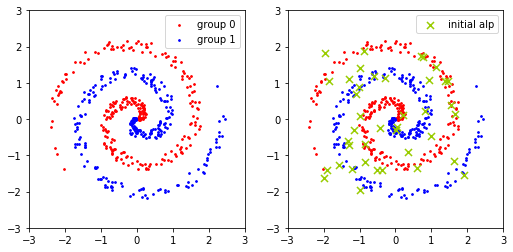

In [21]:
D = 2
K = 40
N = 500
data = DataSet()
alp = 2 * 2 * (np.random.rand(D, K) - 0.5)
phi = 2 * 2 * (np.random.rand(1, K + 1) - 0.5)

plt.rcParams['figure.figsize'] = (8.5, 4.0)
ds1, ds2, x, w = data.generate_data_set_dim2_nonlinear(N)
ds = {'1': ds1, '2': ds2}
init = plt.scatter(alp[0], alp[1], s=50, c=(0.6, 0.8, 0.), marker='x')
plt.legend([init], ["initial alp"])

# Vanilla gradient descent<a class="anchor" id="vanilla"></a>

This is one of the simplest kind. Namely, having computed the gradient, updates are done exactly the opposite direction.

$$\begin{align}
direction \quad & = &\quad - gradient \\
learning\,rate \quad & = &\quad common\,to\,all\,the\,parameters\\
samples\,taken\,into\,account \quad & = &\quad all
\end{align}$$

The update form is as follows.
 
$$\begin{align}
\delta\mathbf{\theta}_{t} \quad & = &\quad - \alpha \partial_{\mathbf{\theta}}L\big(\{\mathbf{x}\}_{i=1}^{N}, \{w\}_{i=1}^{N}, \mathbf{\theta}_{t}\big)\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t}
\end{align}$$

Often, $\alpha$ is annealed as the step progresses. Note that all the samples are taken into account to make one update.

500 steps done. lr : 0.0002, . RBF_var = 0.100. prior_var = 2000.00
durations: 5.6130s
500 steps done. lr : 0.0010, . RBF_var = 0.100. prior_var = 2000.00
durations: 5.5987s
500 steps done. lr : 0.0050, . RBF_var = 0.100. prior_var = 2000.00
durations: 6.4225s
500 steps done. lr : 0.0250, . RBF_var = 0.100. prior_var = 2000.00
durations: 9.8089s
500 steps done. lr : 0.1250, . RBF_var = 0.100. prior_var = 2000.00
durations: 6.8824s


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


2 steps done. lr : 0.6250, . RBF_var = 0.100. prior_var = 2000.00
durations: 0.0261s


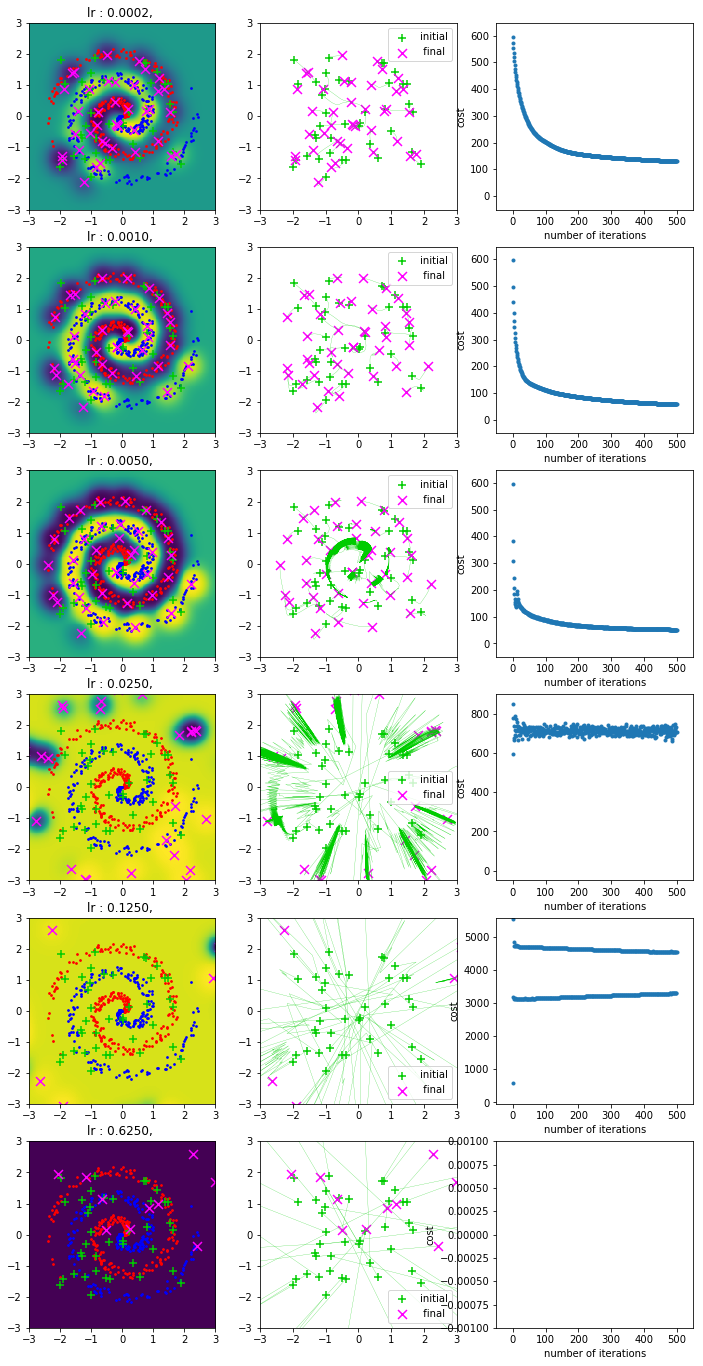

In [22]:
nstep = 500
nbatch = N
sgps = 2000.0
lmd = 0.1
method = 'vanilla'
rates = [{'lr': 0.0002},
         {'lr': 0.0010},
         {'lr': 0.0050},
         {'lr': 0.0250},
         {'lr': 0.1250},
         {'lr': 0.6250}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

# Stochastic gradient descent<a class="anchor" id="sgd"></a>

When the number of samples is very large, it could be computationally expensive to take into account all the samples just for one update. Thus, it'd be faster to deal with a subset of the samples to make an update. One extreme is to randomly pick one sample for every update. Naturally, the update'd be stochastic as the direction and step size would not be averaged over all the samples.

$$\begin{align}
direction \quad & = &\quad - gradient \\
learning\,rate \quad & = &\quad common\,to\,all\,the\,parameters\\
samples\,taken\,into\,account \quad & = &\quad random\,single\,sample
\end{align}$$

The update form is as follows.
 
$$\begin{align}
\delta\mathbf{\theta}_{t} \quad & = &\quad - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{x}_{i}, w_{i}, \mathbf{\theta}_{t}\big)\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t}
\end{align}$$

Often, $\alpha$ is annealed as the step progresses. 

In [ ]:
nstep = 500
nbatch = 1
sgps = 2000.0
lmd = 0.1
method = 'stochastic'
rates = [{'lr': 0.0002},
         {'lr': 0.0010},
         {'lr': 0.0050},
         {'lr': 0.0250},
         {'lr': 0.1250},
         {'lr': 0.6250}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

# Minibatch gradient descent<a class="anchor" id="minibatch"></a>

The stochastic gradient descent is somewhat extreme as it only picks one sample at a time. We may take more samples at a time, especially given it'd exploit parallel array computations of numpy (or supposedly many modern computational algos). Let's say we randomly pick tens to hundred of samples at a time. Compared to the SDG, the updates are more averaged.

$$\begin{align}
direction \quad & = &\quad - gradient \\
learning\,rate \quad & = &\quad common\,to\,all\,the\,parameters\\
samples\,taken\,into\,account \quad & = &\quad tens\, to\, hundred \,of\,samples
\end{align}$$

The update form is as follows.
 
$$\begin{align}
\delta \mathbf{\theta}_{t} \quad & = &\quad - \alpha \partial_{\mathbf{\theta}}L\big(\{\mathbf{x}\}_{subset}, \{w\}_{subset}, \mathbf{\theta}_{t}\big)\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta \mathbf{\theta}_{t} 
\end{align}$$

Often, $\alpha$ is annealed as the step progresses.

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'minibatch'
rates = [{'lr': 0.0002},
         {'lr': 0.0010},
         {'lr': 0.0050},
         {'lr': 0.0250},
         {'lr': 0.1250},
         {'lr': 0.6250}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

# Momentum gradient descent<a class="anchor" id="momentum"></a>

The momentum update accumulates the updates with some "coherence time", namely accumulates the past updates weighted exponentially with a decay constant of your choice $\beta_{1}$ added with the current (minus) gradient weighted with $\alpha$. Naturally, thus, the direction is, in general, not along the gradient at the local point under concern. This is in contrast with the gradient descent which only concerns the gradient at every local point. One of the benefits of this method is, upon moving around the bottom of a ridge where the gradient along the ridge is quite small as opposed to the perpendicular directdion to the ridge, to facilitate the tranjectory of the updates to traverse along the ridge rather than to oscillate perpendicularly to the ridge. The potential problem is that it can approach a (local/global) minimum with a too large momentum and might overshoot it.

$$\begin{align}
direction \quad & = &\quad not\, - gradient \\
learning\,rate \quad & = &\quad common\\
samples\,taken\,into\,account \quad & = &\quad all\,or\,subset
\end{align}$$

The update form is as follows.
 
$$\begin{align}
\delta\mathbf{\theta}_{t} \quad & = &\quad \beta_{1}\delta\mathbf{\theta}_{t-1} - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t} 
\end{align}$$

Let us contrast it to the "normal" gradient descent.

$$\begin{align}
momentum: \qquad \delta\mathbf{\theta}_{t} \quad & = &\quad \beta_{1}\delta\mathbf{\theta}_{t-1} - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\\
normal: \qquad \delta \mathbf{\theta}_{t} \quad & = &\quad - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big) 
\end{align}$$

Often, $\alpha$ is annealed as the step progresses. Here, we omitted arguments $\{\mathbf{x}\}$ and $\{w\}$ for the  notational brevity: $L\big(\{\mathbf{x}\}, \{w\}, \mathbf{\theta}_{t}\big) \Rightarrow L\big(\mathbf{\theta}_{t}\big)$. Note that all the operations are component-wise. 

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'momentum'
rates = [{'lr': 0.0002, 'b1': 0.95},
         {'lr': 0.0010, 'b1': 0.95},
         {'lr': 0.0050, 'b1': 0.95},
         {'lr': 0.0250, 'b1': 0.95},
         {'lr': 0.1250, 'b1': 0.95},
         {'lr': 0.6250, 'b1': 0.95}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'momentum'
rates = [{'lr': 0.0010, 'b1': 0.99},
         {'lr': 0.0010, 'b1': 0.90},
         {'lr': 0.0010, 'b1': 0.70},
         {'lr': 0.0010, 'b1': 0.50},
         {'lr': 0.0010, 'b1': 0.30},
         {'lr': 0.0010, 'b1': 0.10}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta, costs, alps = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta, costs, alps)

# Nesterov's accelerated momentum gradient descent<a class="anchor" id="nag"></a>

The Nesterov momentum update improves the momentum update by "peeking" the gradient at the location ahead which is supposedly reached by the momentum update. The idea is to navigate the trajectory by taking into account the forecast of the gradient ahead and make an update more smartly.

$$\begin{align}
direction \quad & = &\quad not - gradient \\
learning\,rate \quad & = &\quad common\\
samples\,taken\,into\,account \quad & = &\quad all\,or\,subset
\end{align}$$

The update form would look as follows.

$$\begin{align}
\mathbf{\theta}_{t, ahead}  \quad & = &\quad \mathbf{\theta}_{t} + \beta_{1}\delta\mathbf{\theta}_{t-1}\\
\delta\mathbf{\theta}_{t} \quad & = &\quad \beta_{1}\delta\mathbf{\theta}_{t-1} - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t, ahead}\big)\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t}
\end{align}$$

Just to contrast, let's review the "classic" momentum update.

$$\begin{align}
Nesterov: \qquad \delta\mathbf{\theta}_{t} \quad & = &\quad \beta_{1}\delta\mathbf{\theta}_{t-1} - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}+ \beta_{1}\delta\mathbf{\theta}_{t-1}\big)\\
classic: \qquad \delta\mathbf{\theta}_{t} \quad & = &\quad \beta_{1}\delta\mathbf{\theta}_{t-1} - \alpha \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big) \qquad \quad \,\,\,\,\,
\end{align}$$

Although this is conceptually transparent, it'd be more convenient to express it in a "momentum update"-like form. We'll come back to this. Note that all the operations are component-wise. 


Often, $\alpha$ is annealed as the step progresses. Here, we omitted arguments $\{\mathbf{x}\}$ and $\{w\}$ for notational brevity: $L\big(\{\mathbf{x}\}, \{w\}, \mathbf{\theta}_{t}\big) \Rightarrow L\big(\mathbf{\theta}_{t}\big)$.

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'nesterov'
rates = [{'lr': 0.0002, 'b1': 0.95},
         {'lr': 0.0010, 'b1': 0.95},
         {'lr': 0.0050, 'b1': 0.95},
         {'lr': 0.0250, 'b1': 0.95},
         {'lr': 0.1250, 'b1': 0.95},
         {'lr': 0.6250, 'b1': 0.95}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'nesterov'
rates = [{'lr': 0.0010, 'b1': 0.99},
         {'lr': 0.0010, 'b1': 0.90},
         {'lr': 0.0010, 'b1': 0.70},
         {'lr': 0.0010, 'b1': 0.50},
         {'lr': 0.0010, 'b1': 0.30},
         {'lr': 0.0010, 'b1': 0.10}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

# Adagrad (adaptive subgradient methods)<a class="anchor" id="adagrad"></a>

Adagrad effectively updates the learning rates differently for each parameter by accumulating the squared sum of the previous gradients. The learning rates for components that tend to have a bigger grandient would be relatively suppressed while that for components that tend to be small are enlarged. However, as can be seen, the "suppression  effect" might be rather excessively agressively.

$$\begin{align}
direction \quad & = &\quad not - gradient \\
learning\,rate \quad & = &\quad different\\
samples\,taken\,into\,account \quad & = &\quad all\,or\,subset
\end{align}$$

The update form is as follows, with $gss_{t=0} = \mathbf{0}$ where $gss$ abbreviates gradient squared sum.

$$\begin{align}
gss_{t}  \quad & = &\quad gss_{t-1} + \big(\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\big)^{2}  && \qquad component-wise\\
\delta\mathbf{\theta}_{t} \quad & = &\quad - \frac{\alpha}{\sqrt{gss_{t}} + \epsilon} \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)  && \qquad component-wise\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t}
\end{align}$$

Emphasize that all the operations are component-wise to avoid any confusion.

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'adagrad'
rates = [{'lr': 0.0002, 'b1': 0.95},
         {'lr': 0.0010, 'b1': 0.95},
         {'lr': 0.0050, 'b1': 0.95},
         {'lr': 0.0250, 'b1': 0.95},
         {'lr': 0.1250, 'b1': 0.95},
         {'lr': 0.6250, 'b1': 0.95}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'adagrad'
rates = [{'lr': 0.1250, 'b1': 0.99},
         {'lr': 0.1250, 'b1': 0.90},
         {'lr': 0.1250, 'b1': 0.70},
         {'lr': 0.0250, 'b1': 0.50},
         {'lr': 0.1250, 'b1': 0.30},
         {'lr': 0.1250, 'b1': 0.10}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

# RMSprop<a class="anchor" id="rms"></a>

The RMSprop adds "coherence time" or "memory effect" to $gss_{t}$ by add the gradients with some decay constant $\beta_{2}$. Thus, the Adagrad's aggresive attenuation of the learning rate can now be softened.

$$\begin{align}
direction \quad & = &\quad not - gradient \\
learning\,rate \quad & = &\quad different\\
samples\,taken\,into\,account \quad & = &\quad all\,or\,subset
\end{align}$$

The update form is as follows, with $gss_{t=0} = \mathbf{0}$ where $gss$ abbreviates gradient squared sum.

$$\begin{align}
gss_{t}  \quad & = &\quad \beta_{2} * gss_{t-1} + (1 -\beta_{2} )\big(\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\big)^{2} && \qquad component-wise\\
\delta\mathbf{\theta}_{t} \quad & = &\quad - \frac{\alpha}{\sqrt{gss_{t}} + \epsilon} \partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big) && \qquad component-wise\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t}
\end{align}$$

Note that all the operations are component-wise. Let us emphasize the difference between Adagrad and RMSprop

$$\begin{align}
RMSprop: \qquad gss_{t}  \quad & = &\quad \beta_{2} * gss_{t-1} + (1 -\beta_{2} )\big(\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\big)^{2}\\
Adagrad : \qquad gss_{t}  \quad & = &\quad gss_{t-1} + \qquad\,\,\,\,\,\, \big(\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\big)^{2}
\end{align}$$

In principle, the prefactor in front of $\big(\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\big)^{2}$ for RMSprop is not necessary. But that's what it is.

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'rmsprop'
rates = [{'lr': 0.0002, 'b2': 0.95},
         {'lr': 0.0010, 'b2': 0.95},
         {'lr': 0.0050, 'b2': 0.95},
         {'lr': 0.0250, 'b2': 0.95},
         {'lr': 0.1250, 'b2': 0.95},
         {'lr': 0.6250, 'b2': 0.95}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'rmsprop'
rates = [{'lr': 0.0250, 'b2': 0.99},
         {'lr': 0.0250, 'b2': 0.90},
         {'lr': 0.0250, 'b2': 0.70},
         {'lr': 0.0250, 'b2': 0.50},
         {'lr': 0.0250, 'b2': 0.30},
         {'lr': 0.0250, 'b2': 0.10}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

# Adam (adaptive estimates of lower-order moments)<a class="anchor" id="adam"></a>

Adam adds momentum feature to RMSprop, thus, employing two parameters $\beta_{1}$ and $\beta_{2}$. 

$$\begin{align}
direction \quad & = &\quad not - gradient \\
learning\,rate \quad & = &\quad different\\
samples\,taken\,into\,account \quad & = &\quad all\,or\,subset
\end{align}$$

The update form is as follows, $gs_{t=0} = \mathbf{0}$.

$$\begin{align}
gs_{t} \quad & = &\quad \beta_{1}gs_{t-1} + (1 -\beta_{1})\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big) && \qquad component-wise\\
gss_{t}  \quad & = &\quad \beta_{2} * gss_{t-1} + (1 -\beta_{2} )\big(\partial_{\mathbf{\theta}}L\big(\mathbf{\theta}_{t}\big)\big)^{2} && \qquad component-wise\\
\delta\mathbf{\theta}_{t} \quad & = &\quad - \frac{\alpha}{\sqrt{gss_{t}} + \epsilon}gs_{t} && \qquad component-wise\\
\mathbf{\theta}_{t+1} \quad & = &\quad \mathbf{\theta}_{t} + \delta\mathbf{\theta}_{t}
\end{align}$$

Note that all the operations are component-wise.

500 steps done. lr : 0.0002, b1 : 0.9500, b2 : 0.9500, . RBF_var = 0.100. prior_var = 2000.00
durations: 6.7146s
500 steps done. lr : 0.0010, b1 : 0.9500, b2 : 0.9500, . RBF_var = 0.100. prior_var = 2000.00
durations: 6.8708s
500 steps done. lr : 0.0050, b1 : 0.9500, b2 : 0.9500, . RBF_var = 0.100. prior_var = 2000.00
durations: 6.9574s
500 steps done. lr : 0.0250, b1 : 0.9500, b2 : 0.9500, . RBF_var = 0.100. prior_var = 2000.00
durations: 7.0040s


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


431 steps done. lr : 0.1250, b1 : 0.9500, b2 : 0.9500, . RBF_var = 0.100. prior_var = 2000.00
durations: 5.9082s
91 steps done. lr : 0.6250, b1 : 0.9500, b2 : 0.9500, . RBF_var = 0.100. prior_var = 2000.00
durations: 1.2678s


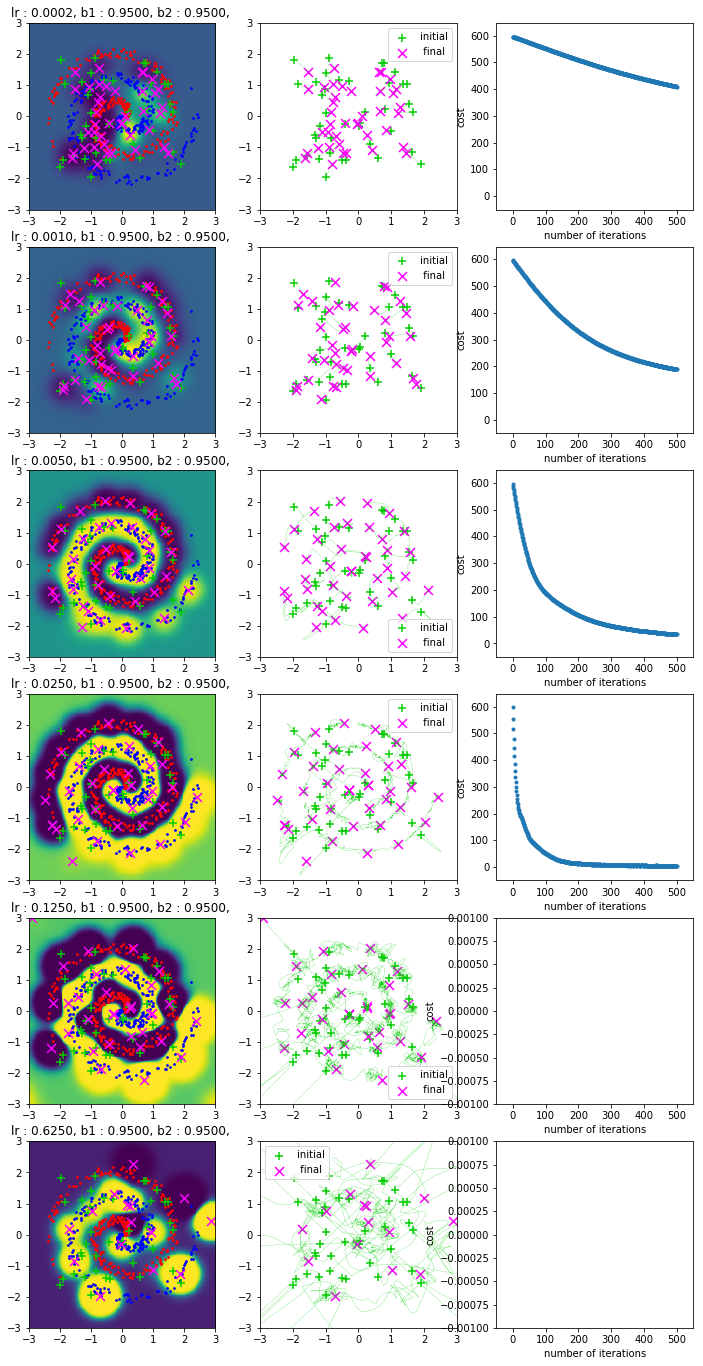

In [28]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'adam'
rates = [{'lr': 0.0002, 'b1': 0.95, 'b2': 0.95},
         {'lr': 0.0010, 'b1': 0.95, 'b2': 0.95},
         {'lr': 0.0050, 'b1': 0.95, 'b2': 0.95},
         {'lr': 0.0250, 'b1': 0.95, 'b2': 0.95},
         {'lr': 0.1250, 'b1': 0.95, 'b2': 0.95},
         {'lr': 0.6250, 'b1': 0.95, 'b2': 0.95}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'adam'
rates = [{'lr': 0.0250, 'b1': 0.95, 'b2': 0.99},
         {'lr': 0.0250, 'b1': 0.95, 'b2': 0.90},
         {'lr': 0.0250, 'b1': 0.95, 'b2': 0.70},
         {'lr': 0.0250, 'b1': 0.95, 'b2': 0.50},
         {'lr': 0.0250, 'b1': 0.95, 'b2': 0.30},
         {'lr': 0.0250, 'b1': 0.95, 'b2': 0.10}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'adam'
rates = [{'lr': 0.0250, 'b1': 0.99, 'b2': 0.95},
         {'lr': 0.0250, 'b1': 0.90, 'b2': 0.95},
         {'lr': 0.0250, 'b1': 0.70, 'b2': 0.95},
         {'lr': 0.0250, 'b1': 0.50, 'b2': 0.95},
         {'lr': 0.0250, 'b1': 0.30, 'b2': 0.95},
         {'lr': 0.0250, 'b1': 0.10, 'b2': 0.95}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
nstep = 500
nbatch = 100
sgps = 2000.0
lmd = 0.1
method = 'adam'
rates = [{'lr': 0.0250, 'b1': 0.99, 'b2': 0.99},
         {'lr': 0.0250, 'b1': 0.90, 'b2': 0.90},
         {'lr': 0.0250, 'b1': 0.70, 'b2': 0.70},
         {'lr': 0.0250, 'b1': 0.50, 'b2': 0.50},
         {'lr': 0.0250, 'b1': 0.30, 'b2': 0.30},
         {'lr': 0.0250, 'b1': 0.10, 'b2': 0.10}]

plt.rcParams['figure.figsize'] = (12.0, len(rates) * 4.0)
for rep, rate in enumerate(rates):
    ax = 3 * rep + 1
    gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
    theta = gd.optimization(phi, alp)
    gd.plot_output(len(rates), ax, ds, theta)

In [ ]:
def kaka(*args):
    print(args[0].lmd)

pipi = 10
gd = GradientDescent(x, w, phi, alp, lmd, sgps, nstep, nbatch, rate, method)
kaka(gd, pipi)